# train

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def run_online(env, RL, ratio, elist): # Validation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.pro_choose_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return eva
        
def run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio): #Training
    check = 999999
    tra_av_errs = []#放的是每50回合训练集上的平均误差
    val_av_errs = []#放的是每50回合验证集上的平均误差
    for r in range(Round):
        env.shuffle()
        episode = 0
        for i in range(0, traj_amount, show_time):
            train_ep_errs = []
            start_t = time.time()
            for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
                buffer_size = int(ratio*len(env.ori_traj_set[episode]))
                # extreme cases
                if buffer_size < 3:
                    episode += 1
                    continue
                steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
                for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
                    if index == steps - 1:#如果已经是轨迹最后一个点
                        done = True
                    else:
                        done = False
                    action = RL.pro_choose_action(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
                    new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
                    RL.store_transition(state, action, reward)
                    if done:
                        RL.learn()#回合结束开始策略梯度算法学习参数
                        break
                    state = new_state
                train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
                train_ep_errs.append(train_e)
                episode += 1
            
            val_ep_errs = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err = sum(val_ep_errs)/len(val_ep_errs)
            val_av_errs.append(val_av_err)
            tra_av_err = sum(train_ep_errs)/len(train_ep_errs)
            tra_av_errs.append(tra_av_err)
            print('round {} episode {}: Training error: {}, Validation error: {}'.format(r, episode, tra_av_err, val_av_err))
            if val_av_err < check:
                check = val_av_err
                RL.save('./save/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label + '/trained_model.ckpt')
                print('Save model with error {}'.format(val_av_err))
            print('==>current best model is {} with ratio {}'.format(check, ratio))
            print('It costs {}s'.format(time.time()-start_t))
    return tra_av_errs, val_av_errs

def train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()


# evaluate

In [3]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import data_utils as F
import time

def evaluate(env, RL, ratio, elist): # Evaluation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.quick_time_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(eva)/len(eva)

def test(model_path, amount, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    start = time.time()
    effectiveness = evaluate(env, rl, ratio, range(amount))
    print("Effectiveness: %e" %effectiveness)
    print("Training elapsed time = %s", float(time.time() - start))
    return effectiveness    

def test_one_sample(model_path, index, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_one_sample(traj_path, index)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    
    net_time = 0
    step_time = 0
    start_ = time.time()
    eva = []
    buffer_size = int(ratio*len(env.ori_traj_set[0]))
    if buffer_size < 3:
        return
    steps, observation = env.reset(0, buffer_size)
    for index in range(buffer_size, steps):
        if index == steps - 1:
            done = True
        else:
            done = False
        start = time.time()
        action = rl.quick_time_action(observation)
        net_time += float(time.time()-start)
        start = time.time()
        observation_, _ = env.step(0, action, index, done, 'V') #'T' means Training, and 'V' means Validation
        step_time += float(time.time()-start)
        observation = observation_
    eva=env.output(0, 'V') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print("Effectiveness: %e" %eva)
    print("Training elapsed time = %s", float(time.time() - start_))
    print("net_time:",net_time)
    print("step_time:",step_time)   

## sed with ratio 0.1

======loading train data======
It cost 24.181161165237427s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.75s/it]


round 0 episode 50: Training error: 84.12053162582943, Validation error: 53.297343467097335

Save model with error 53.297343467097335
==>current best model is 53.297343467097335 with ratio 0.1
It costs 228.264009475708s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


round 0 episode 100: Training error: 90.05989047367062, Validation error: 53.13647679414274
Save model with error 53.13647679414274
==>current best model is 53.13647679414274 with ratio 0.1
It costs 210.19522428512573s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 0 episode 150: Training error: 93.75849475554749, Validation error: 51.0954955567009
Save model with error 51.0954955567009
==>current best model is 51.0954955567009 with ratio 0.1
It costs 187.22975420951843s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


round 0 episode 200: Training error: 54.679146691757204, Validation error: 54.00938607209105
==>current best model is 51.0954955567009 with ratio 0.1
It costs 210.7668468952179s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


round 0 episode 250: Training error: 132.56034220464596, Validation error: 49.89486481217308
Save model with error 49.89486481217308
==>current best model is 49.89486481217308 with ratio 0.1
It costs 200.5513994693756s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:04<00:00,  2.49s/it]


round 0 episode 300: Training error: 85.32115367923488, Validation error: 52.64935775668933
==>current best model is 49.89486481217308 with ratio 0.1
It costs 261.04078483581543s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.67s/it]


round 0 episode 350: Training error: 199.50461887083839, Validation error: 53.6492591254747
==>current best model is 49.89486481217308 with ratio 0.1
It costs 222.27307271957397s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


round 0 episode 400: Training error: 259.6045401573099, Validation error: 53.31289164188885
==>current best model is 49.89486481217308 with ratio 0.1
It costs 191.22835612297058s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.82s/it]


round 0 episode 450: Training error: 102.40108208960744, Validation error: 53.713426386009886
==>current best model is 49.89486481217308 with ratio 0.1
It costs 236.4440484046936s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


round 0 episode 500: Training error: 69.6969456779984, Validation error: 56.85052055860868
==>current best model is 49.89486481217308 with ratio 0.1
It costs 187.08885884284973s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


round 1 episode 50: Training error: 97.93827611086283, Validation error: 52.09712969337118
==>current best model is 49.89486481217308 with ratio 0.1
It costs 197.81375694274902s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:45<00:00,  2.10s/it]


round 1 episode 100: Training error: 109.72368746824019, Validation error: 53.70704491524203
==>current best model is 49.89486481217308 with ratio 0.1
It costs 249.19948959350586s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 1 episode 150: Training error: 44.134372667520275, Validation error: 51.20570480429836
==>current best model is 49.89486481217308 with ratio 0.1
It costs 200.6731927394867s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.67s/it]


round 1 episode 200: Training error: 74.12582534440736, Validation error: 51.90411801639925
==>current best model is 49.89486481217308 with ratio 0.1
It costs 216.0220763683319s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 1 episode 250: Training error: 110.01197263323085, Validation error: 50.16655403202084
==>current best model is 49.89486481217308 with ratio 0.1
It costs 193.53994464874268s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/it]


round 1 episode 300: Training error: 166.40537952108443, Validation error: 51.721845363392696
==>current best model is 49.89486481217308 with ratio 0.1
It costs 213.04521656036377s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


round 1 episode 350: Training error: 149.51766831078754, Validation error: 53.110167081061306
==>current best model is 49.89486481217308 with ratio 0.1
It costs 228.07653427124023s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 1 episode 400: Training error: 182.6043366034541, Validation error: 51.2045617415389
==>current best model is 49.89486481217308 with ratio 0.1
It costs 212.3900408744812s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]


round 1 episode 450: Training error: 57.21227059352497, Validation error: 52.30188986293835
==>current best model is 49.89486481217308 with ratio 0.1
It costs 235.2848093509674s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


round 1 episode 500: Training error: 110.67677611068662, Validation error: 53.261123554130855
==>current best model is 49.89486481217308 with ratio 0.1
It costs 212.21811604499817s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]


round 2 episode 50: Training error: 62.13196216505594, Validation error: 53.67826808519788
==>current best model is 49.89486481217308 with ratio 0.1
It costs 233.5437843799591s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.62s/it]


round 2 episode 100: Training error: 97.6389054324802, Validation error: 51.65075469315791
==>current best model is 49.89486481217308 with ratio 0.1
It costs 219.12761664390564s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 2 episode 150: Training error: 126.24537642115533, Validation error: 52.038126334707755
==>current best model is 49.89486481217308 with ratio 0.1
It costs 182.7676486968994s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 2 episode 200: Training error: 139.31453610408482, Validation error: 49.553303219635055
Save model with error 49.553303219635055
==>current best model is 49.553303219635055 with ratio 0.1
It costs 195.7829864025116s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


round 2 episode 250: Training error: 74.58105735214751, Validation error: 52.642127992977
==>current best model is 49.553303219635055 with ratio 0.1
It costs 192.021728515625s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.56s/it]


round 2 episode 300: Training error: 120.7312974608874, Validation error: 52.12087972784342
==>current best model is 49.553303219635055 with ratio 0.1
It costs 216.30270743370056s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 2 episode 350: Training error: 68.68159524293864, Validation error: 53.50576777418395
==>current best model is 49.553303219635055 with ratio 0.1
It costs 189.5390808582306s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.88s/it]


round 2 episode 400: Training error: 56.13210989736009, Validation error: 52.569621426806606
==>current best model is 49.553303219635055 with ratio 0.1
It costs 229.42853546142578s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:37<00:00,  1.95s/it]


round 2 episode 450: Training error: 216.33758195711863, Validation error: 50.803420600945955
==>current best model is 49.553303219635055 with ratio 0.1
It costs 228.99882459640503s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 2 episode 500: Training error: 86.47102523312313, Validation error: 50.65649745500797
==>current best model is 49.553303219635055 with ratio 0.1
It costs 191.74056816101074s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.10s/it]


round 3 episode 50: Training error: 76.11407644737908, Validation error: 52.825751291870446
==>current best model is 49.553303219635055 with ratio 0.1
It costs 235.98107361793518s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


round 3 episode 100: Training error: 65.4141619910881, Validation error: 52.40258600082447
==>current best model is 49.553303219635055 with ratio 0.1
It costs 198.75254774093628s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.26s/it]


round 3 episode 150: Training error: 103.52139332469646, Validation error: 53.05478464567848
==>current best model is 49.553303219635055 with ratio 0.1
It costs 195.87118458747864s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 3 episode 200: Training error: 88.97543849495895, Validation error: 55.57571122725445
==>current best model is 49.553303219635055 with ratio 0.1
It costs 193.66474652290344s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 3 episode 250: Training error: 139.39113395745903, Validation error: 50.93093753701749
==>current best model is 49.553303219635055 with ratio 0.1
It costs 191.90475296974182s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.68s/it]


round 3 episode 300: Training error: 106.80414155251046, Validation error: 49.835238090160466
==>current best model is 49.553303219635055 with ratio 0.1
It costs 216.23939394950867s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.44s/it]


round 3 episode 350: Training error: 225.28209738835108, Validation error: 51.03434977382271
==>current best model is 49.553303219635055 with ratio 0.1
It costs 204.2570779323578s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


round 3 episode 400: Training error: 244.80370398007668, Validation error: 50.51798553713198
==>current best model is 49.553303219635055 with ratio 0.1
It costs 186.86013865470886s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


round 3 episode 450: Training error: 78.37419409395146, Validation error: 50.5204679650983
==>current best model is 49.553303219635055 with ratio 0.1
It costs 213.38345217704773s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.72s/it]


round 3 episode 500: Training error: 58.490580993068924, Validation error: 51.03344057994272
==>current best model is 49.553303219635055 with ratio 0.1
It costs 223.01979851722717s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 4 episode 50: Training error: 197.85925759252376, Validation error: 50.73820232601898
==>current best model is 49.553303219635055 with ratio 0.1
It costs 194.15802240371704s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 4 episode 100: Training error: 59.71237583731334, Validation error: 51.702774978995066
==>current best model is 49.553303219635055 with ratio 0.1
It costs 194.4973292350769s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.79s/it]


round 4 episode 150: Training error: 116.53646193136116, Validation error: 49.933847810565396
==>current best model is 49.553303219635055 with ratio 0.1
It costs 272.6940710544586s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 4 episode 200: Training error: 64.64054548669219, Validation error: 50.47655592331908
==>current best model is 49.553303219635055 with ratio 0.1
It costs 199.85764241218567s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.07s/it]


round 4 episode 250: Training error: 91.93496812818874, Validation error: 49.673291778555225
==>current best model is 49.553303219635055 with ratio 0.1
It costs 253.10710501670837s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 4 episode 300: Training error: 260.7996368836619, Validation error: 51.88859156823053
==>current best model is 49.553303219635055 with ratio 0.1
It costs 197.56453680992126s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 4 episode 350: Training error: 48.30141510617078, Validation error: 49.249942039643166
Save model with error 49.249942039643166
==>current best model is 49.249942039643166 with ratio 0.1
It costs 199.3558714389801s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.26s/it]


round 4 episode 400: Training error: 64.46123950472376, Validation error: 50.97997317077666
==>current best model is 49.249942039643166 with ratio 0.1
It costs 205.28185296058655s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


round 4 episode 450: Training error: 59.45438176915245, Validation error: 51.97112970125429
==>current best model is 49.249942039643166 with ratio 0.1
It costs 200.9879593849182s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:02<00:00,  2.45s/it]


round 4 episode 500: Training error: 161.40923631660368, Validation error: 47.963815294758305
Save model with error 47.963815294758305
==>current best model is 47.963815294758305 with ratio 0.1
It costs 257.0256609916687s
Training elapsed time = %s 10607.071767807007


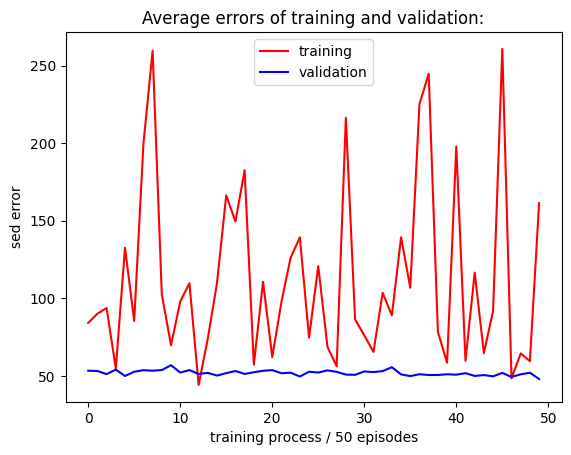

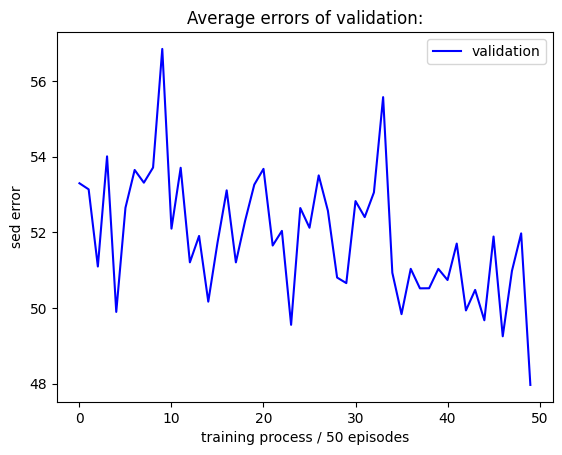

In [4]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 12.419131994247437s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 0 episode 50: Training error: 38.88412128002644, Validation error: 25.211972478135927

Save model with error 25.211972478135927
==>current best model is 25.211972478135927 with ratio 0.1
It costs 186.65548586845398s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 0 episode 100: Training error: 76.76390732695512, Validation error: 25.455045834651763
==>current best model is 25.211972478135927 with ratio 0.1
It costs 172.39362955093384s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 0 episode 150: Training error: 53.07507807803221, Validation error: 22.501273104800497
Save model with error 22.501273104800497
==>current best model is 22.501273104800497 with ratio 0.1
It costs 177.55201506614685s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 0 episode 200: Training error: 22.036274436426922, Validation error: 24.238646984832897
==>current best model is 22.501273104800497 with ratio 0.1
It costs 175.35299229621887s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:39<00:00,  2.00s/it]


round 0 episode 250: Training error: 40.753868177140454, Validation error: 24.17214852901411
==>current best model is 22.501273104800497 with ratio 0.1
It costs 225.82910585403442s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:56<00:00,  2.34s/it]


round 0 episode 300: Training error: 56.350086806654, Validation error: 23.872141506925637
==>current best model is 22.501273104800497 with ratio 0.1
It costs 246.45259284973145s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/it]


round 0 episode 350: Training error: 112.56970051908455, Validation error: 24.239667991227112
==>current best model is 22.501273104800497 with ratio 0.1
It costs 201.8626148700714s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 0 episode 400: Training error: 47.816480737947366, Validation error: 20.083958788701647
Save model with error 20.083958788701647
==>current best model is 20.083958788701647 with ratio 0.1
It costs 185.95303869247437s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 0 episode 450: Training error: 50.015830027379835, Validation error: 23.215588710966266
==>current best model is 20.083958788701647 with ratio 0.1
It costs 191.67710828781128s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 0 episode 500: Training error: 24.931159010467944, Validation error: 23.582093669850007
==>current best model is 20.083958788701647 with ratio 0.1
It costs 188.1863033771515s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 1 episode 50: Training error: 36.57734602433875, Validation error: 21.14214263887595
==>current best model is 20.083958788701647 with ratio 0.1
It costs 175.77176547050476s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.04s/it]


round 1 episode 100: Training error: 43.22231039764302, Validation error: 22.41537482206103
==>current best model is 20.083958788701647 with ratio 0.1
It costs 226.32250094413757s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.76s/it]


round 1 episode 150: Training error: 32.84201773402523, Validation error: 20.28125796264068
==>current best model is 20.083958788701647 with ratio 0.1
It costs 211.69351601600647s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


round 1 episode 200: Training error: 31.095244151980154, Validation error: 22.726426247639353
==>current best model is 20.083958788701647 with ratio 0.1
It costs 187.6401069164276s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.72s/it]


round 1 episode 250: Training error: 29.065992230040994, Validation error: 20.427104962329263
==>current best model is 20.083958788701647 with ratio 0.1
It costs 210.45579195022583s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


round 1 episode 300: Training error: 21.85643129183677, Validation error: 19.255759325401637
Save model with error 19.255759325401637
==>current best model is 19.255759325401637 with ratio 0.1
It costs 179.28016138076782s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 1 episode 350: Training error: 44.08717065759839, Validation error: 20.561625433465665
==>current best model is 19.255759325401637 with ratio 0.1
It costs 184.29643273353577s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


round 1 episode 400: Training error: 89.88842574811822, Validation error: 19.966030091699
==>current best model is 19.255759325401637 with ratio 0.1
It costs 189.66864204406738s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


round 1 episode 450: Training error: 99.51143489510099, Validation error: 20.827254755422224
==>current best model is 19.255759325401637 with ratio 0.1
It costs 179.44213271141052s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


round 1 episode 500: Training error: 32.587904143403506, Validation error: 19.246516449278815
Save model with error 19.246516449278815
==>current best model is 19.246516449278815 with ratio 0.1
It costs 185.623220205307s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.08it/s]


round 2 episode 50: Training error: 31.266684977722417, Validation error: 19.340972113830027
==>current best model is 19.246516449278815 with ratio 0.1
It costs 166.95507550239563s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.72s/it]


round 2 episode 100: Training error: 32.152856128720764, Validation error: 21.257929747771037
==>current best model is 19.246516449278815 with ratio 0.1
It costs 207.14393973350525s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 2 episode 150: Training error: 24.277077821128252, Validation error: 20.750398846276113
==>current best model is 19.246516449278815 with ratio 0.1
It costs 170.56663036346436s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


round 2 episode 200: Training error: 48.82114640177313, Validation error: 21.73976036845616
==>current best model is 19.246516449278815 with ratio 0.1
It costs 213.65813994407654s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 2 episode 250: Training error: 100.05436196011898, Validation error: 19.805003332766745
==>current best model is 19.246516449278815 with ratio 0.1
It costs 180.9520263671875s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


round 2 episode 300: Training error: 55.7564036083648, Validation error: 21.89134074196196
==>current best model is 19.246516449278815 with ratio 0.1
It costs 176.3146529197693s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.32s/it]


round 2 episode 350: Training error: 30.214544866210804, Validation error: 18.975615108444224
Save model with error 18.975615108444224
==>current best model is 18.975615108444224 with ratio 0.1
It costs 186.68937349319458s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


round 2 episode 400: Training error: 31.5791905722817, Validation error: 21.221099976248542
==>current best model is 18.975615108444224 with ratio 0.1
It costs 197.59814524650574s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.24s/it]


round 2 episode 450: Training error: 24.905116786514306, Validation error: 20.09457003510727
==>current best model is 18.975615108444224 with ratio 0.1
It costs 182.56395721435547s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 500: Training error: 20.828383985927893, Validation error: 19.825028199501798
==>current best model is 18.975615108444224 with ratio 0.1
It costs 180.70911526679993s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 3 episode 50: Training error: 67.75299172640644, Validation error: 20.19930758563651
==>current best model is 18.975615108444224 with ratio 0.1
It costs 175.36545777320862s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


round 3 episode 100: Training error: 58.58195869720076, Validation error: 19.868732458831758
==>current best model is 18.975615108444224 with ratio 0.1
It costs 167.35456895828247s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


round 3 episode 150: Training error: 20.90162093319238, Validation error: 24.004156542015203
==>current best model is 18.975615108444224 with ratio 0.1
It costs 166.92365980148315s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 3 episode 200: Training error: 119.6874661308513, Validation error: 20.352919195202254
==>current best model is 18.975615108444224 with ratio 0.1
It costs 179.3043568134308s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


round 3 episode 250: Training error: 52.516182263421896, Validation error: 21.135997842023524
==>current best model is 18.975615108444224 with ratio 0.1
It costs 213.9258029460907s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/it]


round 3 episode 300: Training error: 19.205784391012113, Validation error: 18.18378918533291
Save model with error 18.18378918533291
==>current best model is 18.18378918533291 with ratio 0.1
It costs 195.51191544532776s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


round 3 episode 350: Training error: 63.22503295108825, Validation error: 22.946421711275157
==>current best model is 18.18378918533291 with ratio 0.1
It costs 176.2665388584137s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


round 3 episode 400: Training error: 29.511529048152706, Validation error: 19.670936204915396
==>current best model is 18.18378918533291 with ratio 0.1
It costs 201.23012328147888s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.80s/it]


round 3 episode 450: Training error: 17.141709857392062, Validation error: 19.242650380861438
==>current best model is 18.18378918533291 with ratio 0.1
It costs 211.60859370231628s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 3 episode 500: Training error: 74.13185645907728, Validation error: 20.014580211443235
==>current best model is 18.18378918533291 with ratio 0.1
It costs 182.83644890785217s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 4 episode 50: Training error: 18.737595088643385, Validation error: 19.57234617912159
==>current best model is 18.18378918533291 with ratio 0.1
It costs 172.67938494682312s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 4 episode 100: Training error: 41.43981781767386, Validation error: 19.699209509433082
==>current best model is 18.18378918533291 with ratio 0.1
It costs 170.7896749973297s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 4 episode 150: Training error: 52.837167412590205, Validation error: 19.679397550848442
==>current best model is 18.18378918533291 with ratio 0.1
It costs 171.46504664421082s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


round 4 episode 200: Training error: 129.33967325657073, Validation error: 18.872438603889947
==>current best model is 18.18378918533291 with ratio 0.1
It costs 173.9674208164215s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 4 episode 250: Training error: 23.494183088182034, Validation error: 19.530816441897514
==>current best model is 18.18378918533291 with ratio 0.1
It costs 182.09016489982605s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


round 4 episode 300: Training error: 31.215867831390934, Validation error: 20.27437352487577
==>current best model is 18.18378918533291 with ratio 0.1
It costs 183.8187370300293s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


round 4 episode 350: Training error: 15.399827950437423, Validation error: 20.61340225446138
==>current best model is 18.18378918533291 with ratio 0.1
It costs 214.1583766937256s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:29<00:00,  1.79s/it]


round 4 episode 400: Training error: 38.97967948567591, Validation error: 21.82038138636051
==>current best model is 18.18378918533291 with ratio 0.1
It costs 211.4418351650238s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


round 4 episode 450: Training error: 77.28244670934154, Validation error: 21.033034222209423
==>current best model is 18.18378918533291 with ratio 0.1
It costs 195.23542165756226s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


round 4 episode 500: Training error: 21.304487694273547, Validation error: 21.57940166175316
==>current best model is 18.18378918533291 with ratio 0.1
It costs 204.23252773284912s
Training elapsed time = %s 9495.468403339386


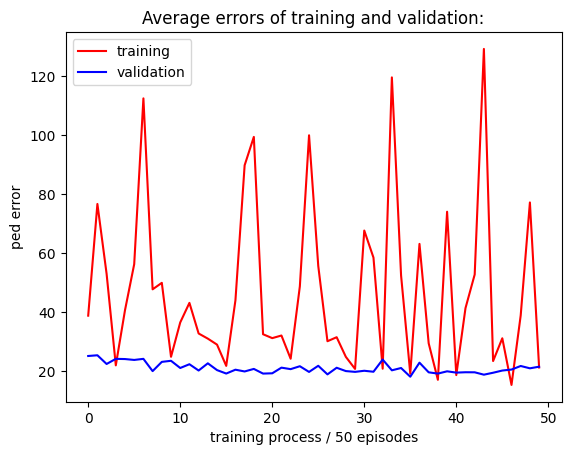

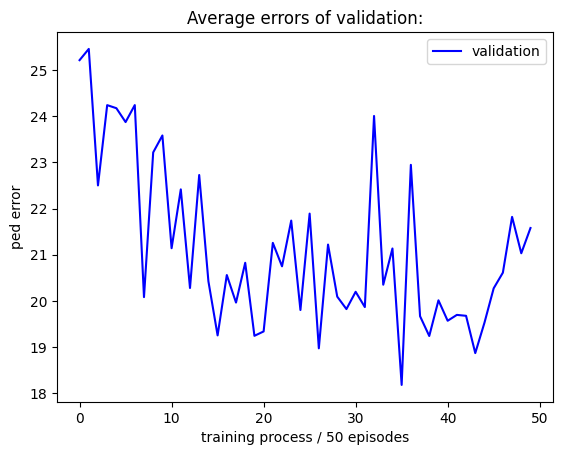

In [4]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 12.113851547241211s.


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


round 0 episode 50: Training error: 189.74375176816613, Validation error: 54.425727809157664
Save model with error 54.425727809157664
==>current best model is 54.425727809157664 with ratio 0.1
It costs 188.74791359901428s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


round 0 episode 100: Training error: 125.18592972122693, Validation error: 53.415148119704206
Save model with error 53.415148119704206
==>current best model is 53.415148119704206 with ratio 0.1
It costs 212.44374299049377s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.07s/it]


round 0 episode 150: Training error: 140.01578212385314, Validation error: 55.93253139594501
==>current best model is 53.415148119704206 with ratio 0.1
It costs 232.9127779006958s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


round 0 episode 200: Training error: 142.58440851903143, Validation error: 54.3164871493411
==>current best model is 53.415148119704206 with ratio 0.1
It costs 209.89965057373047s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


round 0 episode 250: Training error: 76.85445137471488, Validation error: 52.336347349737345
Save model with error 52.336347349737345
==>current best model is 52.336347349737345 with ratio 0.1
It costs 198.43997716903687s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.34s/it]


round 0 episode 300: Training error: 248.76329465072453, Validation error: 52.383385088365586
==>current best model is 52.336347349737345 with ratio 0.1
It costs 201.64451265335083s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.77s/it]


round 0 episode 350: Training error: 83.5520474371266, Validation error: 51.60238191069588
Save model with error 51.60238191069588
==>current best model is 51.60238191069588 with ratio 0.1
It costs 220.8560380935669s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


round 0 episode 400: Training error: 61.29886710905561, Validation error: 51.96820201682022
==>current best model is 51.60238191069588 with ratio 0.1
It costs 170.87508821487427s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


round 0 episode 450: Training error: 47.38208316120452, Validation error: 51.210530481780886
Save model with error 51.210530481780886
==>current best model is 51.210530481780886 with ratio 0.1
It costs 194.2316517829895s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


round 0 episode 500: Training error: 74.27015431771439, Validation error: 52.72890605010289
==>current best model is 51.210530481780886 with ratio 0.1
It costs 193.72966241836548s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.38s/it]


round 1 episode 50: Training error: 72.68958798696355, Validation error: 49.78601390739124
Save model with error 49.78601390739124
==>current best model is 49.78601390739124 with ratio 0.1
It costs 199.3458971977234s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:45<00:00,  2.11s/it]


round 1 episode 100: Training error: 249.03450431957367, Validation error: 51.4463644781255
==>current best model is 49.78601390739124 with ratio 0.1
It costs 234.9925501346588s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it]


round 1 episode 150: Training error: 94.49069875965417, Validation error: 49.275573757476394
Save model with error 49.275573757476394
==>current best model is 49.275573757476394 with ratio 0.1
It costs 204.4546082019806s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it]


round 1 episode 200: Training error: 71.75297792512127, Validation error: 48.62699739103845
Save model with error 48.62699739103845
==>current best model is 48.62699739103845 with ratio 0.1
It costs 186.43001246452332s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 1 episode 250: Training error: 195.5975405442986, Validation error: 46.50673547515556
Save model with error 46.50673547515556
==>current best model is 46.50673547515556 with ratio 0.1
It costs 178.86619997024536s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


round 1 episode 300: Training error: 100.36933627446447, Validation error: 49.46991499780579
==>current best model is 46.50673547515556 with ratio 0.1
It costs 172.39519691467285s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


round 1 episode 350: Training error: 80.71205188092513, Validation error: 50.40429517129243
==>current best model is 46.50673547515556 with ratio 0.1
It costs 206.03469157218933s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.56s/it]


round 1 episode 400: Training error: 42.922624017561, Validation error: 48.54205704712562
==>current best model is 46.50673547515556 with ratio 0.1
It costs 212.11306762695312s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


round 1 episode 450: Training error: 100.34441314791852, Validation error: 49.33973098946935
==>current best model is 46.50673547515556 with ratio 0.1
It costs 201.15520644187927s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]


round 1 episode 500: Training error: 127.45450913544579, Validation error: 45.08077187925931
Save model with error 45.08077187925931
==>current best model is 45.08077187925931 with ratio 0.1
It costs 230.58459949493408s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.28s/it]


round 2 episode 50: Training error: 45.34308839061906, Validation error: 49.93025791771014
==>current best model is 45.08077187925931 with ratio 0.1
It costs 194.55458188056946s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/it]


round 2 episode 100: Training error: 83.47070738107759, Validation error: 49.966133910866255
==>current best model is 45.08077187925931 with ratio 0.1
It costs 210.28116941452026s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.06s/it]


round 2 episode 150: Training error: 44.58091474456542, Validation error: 53.681252260911066
==>current best model is 45.08077187925931 with ratio 0.1
It costs 233.76444578170776s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


round 2 episode 200: Training error: 96.54811118295173, Validation error: 46.951310293356336
==>current best model is 45.08077187925931 with ratio 0.1
It costs 203.65759682655334s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


round 2 episode 250: Training error: 67.30851524355627, Validation error: 51.95728103209447
==>current best model is 45.08077187925931 with ratio 0.1
It costs 199.86573481559753s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 2 episode 300: Training error: 196.08219186573598, Validation error: 48.90984654458251
==>current best model is 45.08077187925931 with ratio 0.1
It costs 181.49324536323547s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 2 episode 350: Training error: 49.70828088588755, Validation error: 50.00807202486118
==>current best model is 45.08077187925931 with ratio 0.1
It costs 190.2681064605713s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


round 2 episode 400: Training error: 154.3625211718822, Validation error: 48.42689352241368
==>current best model is 45.08077187925931 with ratio 0.1
It costs 187.50038743019104s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


round 2 episode 450: Training error: 80.65129446769389, Validation error: 48.895753048621145
==>current best model is 45.08077187925931 with ratio 0.1
It costs 206.4568169116974s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.75s/it]


round 2 episode 500: Training error: 230.74883231239698, Validation error: 48.38096710037339
==>current best model is 45.08077187925931 with ratio 0.1
It costs 217.53738021850586s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


round 3 episode 50: Training error: 39.29195502434016, Validation error: 50.64622653177445
==>current best model is 45.08077187925931 with ratio 0.1
It costs 203.22012853622437s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.38s/it]


round 3 episode 100: Training error: 78.16406765813514, Validation error: 47.458227442485395
==>current best model is 45.08077187925931 with ratio 0.1
It costs 201.24518942832947s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]


round 3 episode 150: Training error: 82.91917525918494, Validation error: 49.64425223972885
==>current best model is 45.08077187925931 with ratio 0.1
It costs 172.57815766334534s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.01s/it]


round 3 episode 200: Training error: 243.6665604070587, Validation error: 50.722090779539734
==>current best model is 45.08077187925931 with ratio 0.1
It costs 231.32864546775818s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.40s/it]


round 3 episode 250: Training error: 92.95362429055254, Validation error: 49.12500630255331
==>current best model is 45.08077187925931 with ratio 0.1
It costs 199.3498876094818s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.97s/it]


round 3 episode 300: Training error: 67.65009327014202, Validation error: 48.23436178394587
==>current best model is 45.08077187925931 with ratio 0.1
It costs 228.53122878074646s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.24s/it]


round 3 episode 350: Training error: 116.89090151378741, Validation error: 50.43084798883775
==>current best model is 45.08077187925931 with ratio 0.1
It costs 243.88279843330383s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 3 episode 400: Training error: 84.23489020794688, Validation error: 50.030644478168185
==>current best model is 45.08077187925931 with ratio 0.1
It costs 189.28307175636292s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


round 3 episode 450: Training error: 128.9689814325485, Validation error: 51.44103324101488
==>current best model is 45.08077187925931 with ratio 0.1
It costs 183.8979299068451s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 3 episode 500: Training error: 150.64753258958038, Validation error: 47.17030756493632
==>current best model is 45.08077187925931 with ratio 0.1
It costs 191.26827573776245s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 4 episode 50: Training error: 212.2475473124208, Validation error: 49.29513660952134
==>current best model is 45.08077187925931 with ratio 0.1
It costs 181.44445729255676s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


round 4 episode 100: Training error: 90.11281176554081, Validation error: 45.894798415633595
==>current best model is 45.08077187925931 with ratio 0.1
It costs 192.30461978912354s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 4 episode 150: Training error: 60.813393304911415, Validation error: 48.063308351877076
==>current best model is 45.08077187925931 with ratio 0.1
It costs 190.0110640525818s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/it]


round 4 episode 200: Training error: 40.11927052372048, Validation error: 46.799263879250695
==>current best model is 45.08077187925931 with ratio 0.1
It costs 198.57808637619019s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


round 4 episode 250: Training error: 66.49264855115177, Validation error: 46.670426549249406
==>current best model is 45.08077187925931 with ratio 0.1
It costs 218.79538655281067s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 4 episode 300: Training error: 116.39302037406122, Validation error: 49.69911830734126
==>current best model is 45.08077187925931 with ratio 0.1
It costs 189.50617122650146s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]


round 4 episode 350: Training error: 176.21953718811642, Validation error: 45.84359533463205
==>current best model is 45.08077187925931 with ratio 0.1
It costs 221.58620762825012s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


round 4 episode 400: Training error: 128.75030867287742, Validation error: 47.48385364346917
==>current best model is 45.08077187925931 with ratio 0.1
It costs 198.0628216266632s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


round 4 episode 450: Training error: 54.79955232186619, Validation error: 46.813110066587214
==>current best model is 45.08077187925931 with ratio 0.1
It costs 197.41307258605957s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.18s/it]


round 4 episode 500: Training error: 80.99637115319189, Validation error: 46.70498755113658
==>current best model is 45.08077187925931 with ratio 0.1
It costs 241.14389419555664s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


round 5 episode 50: Training error: 78.40267248388137, Validation error: 44.2295270042121
Save model with error 44.2295270042121
==>current best model is 44.2295270042121 with ratio 0.1
It costs 219.1012830734253s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:48<00:00,  2.17s/it]


round 5 episode 100: Training error: 100.72539458239154, Validation error: 47.03617240366105
==>current best model is 44.2295270042121 with ratio 0.1
It costs 236.89790272712708s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


round 5 episode 150: Training error: 100.30023812078143, Validation error: 46.75391268695779
==>current best model is 44.2295270042121 with ratio 0.1
It costs 180.20699453353882s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 5 episode 200: Training error: 70.99214363638923, Validation error: 48.557558957237504
==>current best model is 44.2295270042121 with ratio 0.1
It costs 177.03121852874756s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.34s/it]


round 5 episode 250: Training error: 90.28541721385729, Validation error: 45.7168895494609
==>current best model is 44.2295270042121 with ratio 0.1
It costs 196.8125021457672s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


round 5 episode 300: Training error: 224.54541261208243, Validation error: 46.023468528730724
==>current best model is 44.2295270042121 with ratio 0.1
It costs 184.7744598388672s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


round 5 episode 350: Training error: 63.165270240220146, Validation error: 45.94331447763436
==>current best model is 44.2295270042121 with ratio 0.1
It costs 205.71294045448303s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


round 5 episode 400: Training error: 56.91397707134146, Validation error: 45.60075282246852
==>current best model is 44.2295270042121 with ratio 0.1
It costs 220.3778100013733s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/it]


round 5 episode 450: Training error: 57.485861524422226, Validation error: 47.55106837966248
==>current best model is 44.2295270042121 with ratio 0.1
It costs 203.60635542869568s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 5 episode 500: Training error: 106.8270921247273, Validation error: 45.00281592847525
==>current best model is 44.2295270042121 with ratio 0.1
It costs 187.28804230690002s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.67s/it]


round 6 episode 50: Training error: 43.0636617064198, Validation error: 48.143979757293785
==>current best model is 44.2295270042121 with ratio 0.1
It costs 212.20718812942505s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


round 6 episode 100: Training error: 117.53200938509512, Validation error: 48.064340471523884
==>current best model is 44.2295270042121 with ratio 0.1
It costs 184.40698170661926s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 6 episode 150: Training error: 187.9328862224963, Validation error: 48.01250735429875
==>current best model is 44.2295270042121 with ratio 0.1
It costs 198.5668876171112s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


round 6 episode 200: Training error: 61.94590835721844, Validation error: 49.241709170948795
==>current best model is 44.2295270042121 with ratio 0.1
It costs 186.02109694480896s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


round 6 episode 250: Training error: 128.7815244429572, Validation error: 49.58404180316843
==>current best model is 44.2295270042121 with ratio 0.1
It costs 184.42947125434875s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:36<00:00,  1.92s/it]


round 6 episode 300: Training error: 70.58180206508688, Validation error: 52.04065553016771
==>current best model is 44.2295270042121 with ratio 0.1
It costs 225.28865242004395s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.16it/s]


round 6 episode 350: Training error: 81.3899186963505, Validation error: 49.57233712659987
==>current best model is 44.2295270042121 with ratio 0.1
It costs 173.55158615112305s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


round 6 episode 400: Training error: 263.9157244713114, Validation error: 46.96425994263688
==>current best model is 44.2295270042121 with ratio 0.1
It costs 213.1133360862732s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.23s/it]


round 6 episode 450: Training error: 51.32478494084896, Validation error: 47.241295695687356
==>current best model is 44.2295270042121 with ratio 0.1
It costs 239.26047563552856s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]


round 6 episode 500: Training error: 42.008513330911235, Validation error: 46.24613042520157
==>current best model is 44.2295270042121 with ratio 0.1
It costs 195.0975902080536s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


round 7 episode 50: Training error: 73.41529893111394, Validation error: 46.814386773175926
==>current best model is 44.2295270042121 with ratio 0.1
It costs 213.78294253349304s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.46s/it]


round 7 episode 100: Training error: 81.07396190659504, Validation error: 45.90550886913779
==>current best model is 44.2295270042121 with ratio 0.1
It costs 199.92653679847717s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


round 7 episode 150: Training error: 64.70876222118645, Validation error: 48.21884417793437
==>current best model is 44.2295270042121 with ratio 0.1
It costs 176.5464551448822s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:22<00:00,  1.64s/it]


round 7 episode 200: Training error: 215.1756368962506, Validation error: 45.82333852642548
==>current best model is 44.2295270042121 with ratio 0.1
It costs 211.9923927783966s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:29<00:00,  1.80s/it]


round 7 episode 250: Training error: 58.34016490467074, Validation error: 43.482969325952766
Save model with error 43.482969325952766
==>current best model is 43.482969325952766 with ratio 0.1
It costs 218.5315399169922s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.68s/it]


round 7 episode 300: Training error: 110.22211033177982, Validation error: 44.01271314195259
==>current best model is 43.482969325952766 with ratio 0.1
It costs 210.326735496521s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


round 7 episode 350: Training error: 104.81423802844166, Validation error: 44.499967961548116
==>current best model is 43.482969325952766 with ratio 0.1
It costs 177.47830510139465s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it]


round 7 episode 400: Training error: 54.531232902312034, Validation error: 46.96997207183144
==>current best model is 43.482969325952766 with ratio 0.1
It costs 201.2668697834015s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


round 7 episode 450: Training error: 80.29068361056075, Validation error: 45.76162488010908
==>current best model is 43.482969325952766 with ratio 0.1
It costs 205.87708044052124s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 7 episode 500: Training error: 151.88447784565452, Validation error: 46.05880298599276
==>current best model is 43.482969325952766 with ratio 0.1
It costs 189.4791829586029s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.23s/it]


round 8 episode 50: Training error: 119.7847553813629, Validation error: 44.88026940170264
==>current best model is 43.482969325952766 with ratio 0.1
It costs 240.91777992248535s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.30s/it]


round 8 episode 100: Training error: 43.03927593151287, Validation error: 46.63582259477013
==>current best model is 43.482969325952766 with ratio 0.1
It costs 192.24930047988892s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 8 episode 150: Training error: 105.81959034516423, Validation error: 43.87255933073682
==>current best model is 43.482969325952766 with ratio 0.1
It costs 189.82591438293457s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


round 8 episode 200: Training error: 54.60527022538467, Validation error: 45.056732067408944
==>current best model is 43.482969325952766 with ratio 0.1
It costs 210.04401779174805s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


round 8 episode 250: Training error: 163.83986743775216, Validation error: 46.54305976125842
==>current best model is 43.482969325952766 with ratio 0.1
It costs 182.3323962688446s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


round 8 episode 300: Training error: 61.40209704999118, Validation error: 45.197598201294895
==>current best model is 43.482969325952766 with ratio 0.1
It costs 180.501859664917s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:36<00:00,  1.93s/it]


round 8 episode 350: Training error: 66.00050902563414, Validation error: 45.69547619533366
==>current best model is 43.482969325952766 with ratio 0.1
It costs 223.64565086364746s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


round 8 episode 400: Training error: 54.53342221351044, Validation error: 45.87084103558395
==>current best model is 43.482969325952766 with ratio 0.1
It costs 203.50249338150024s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 8 episode 450: Training error: 121.4940230007167, Validation error: 45.56514890596977
==>current best model is 43.482969325952766 with ratio 0.1
It costs 193.84544944763184s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


round 8 episode 500: Training error: 232.16354749863677, Validation error: 43.86830699604123
==>current best model is 43.482969325952766 with ratio 0.1
It costs 186.25807118415833s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 9 episode 50: Training error: 55.48915408503196, Validation error: 44.85540702945534
==>current best model is 43.482969325952766 with ratio 0.1
It costs 190.53148651123047s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


round 9 episode 100: Training error: 293.31267054290845, Validation error: 45.91366539165044
==>current best model is 43.482969325952766 with ratio 0.1
It costs 183.94945645332336s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.55s/it]


round 9 episode 150: Training error: 112.36497907032907, Validation error: 46.92782610182566
==>current best model is 43.482969325952766 with ratio 0.1
It costs 255.2915976047516s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


round 9 episode 200: Training error: 77.40958932388045, Validation error: 46.38947414988044
==>current best model is 43.482969325952766 with ratio 0.1
It costs 195.9635603427887s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 9 episode 250: Training error: 63.7614741982263, Validation error: 44.42768496802362
==>current best model is 43.482969325952766 with ratio 0.1
It costs 187.73920583724976s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


round 9 episode 300: Training error: 81.80126135880523, Validation error: 47.28911240430599
==>current best model is 43.482969325952766 with ratio 0.1
It costs 223.27418208122253s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 9 episode 350: Training error: 73.28731339757095, Validation error: 44.15818856426315
==>current best model is 43.482969325952766 with ratio 0.1
It costs 188.36304140090942s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 9 episode 400: Training error: 63.99716137095146, Validation error: 43.683535429776896
==>current best model is 43.482969325952766 with ratio 0.1
It costs 190.49648332595825s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.42s/it]


round 9 episode 450: Training error: 89.74148529902808, Validation error: 44.57579206445365
==>current best model is 43.482969325952766 with ratio 0.1
It costs 200.50647902488708s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


round 9 episode 500: Training error: 60.60121471209907, Validation error: 45.814058670306046
==>current best model is 43.482969325952766 with ratio 0.1
It costs 199.12651443481445s
Training elapsed time = %s 20196.295841932297


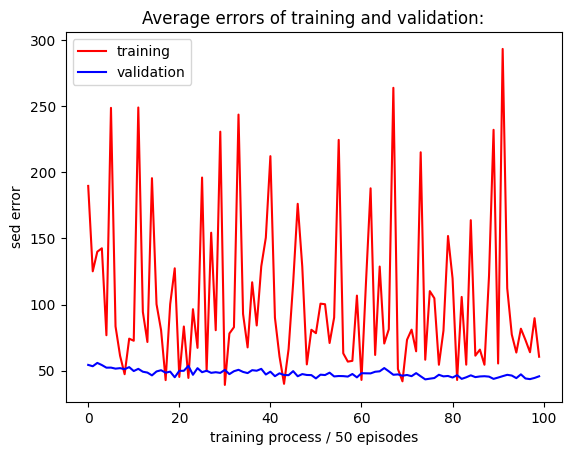

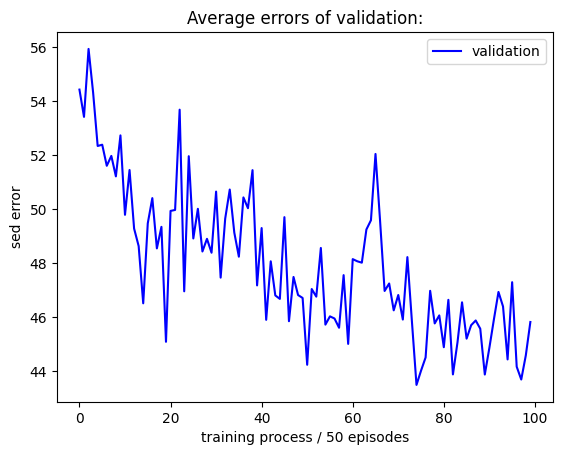

In [5]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 23.452230215072632s.


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


round 0 episode 50: Training error: 129.70614372621426, Validation error: 24.42379807855058
Save model with error 24.42379807855058
==>current best model is 24.42379807855058 with ratio 0.1
It costs 161.9617931842804s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


round 0 episode 100: Training error: 70.29903794201826, Validation error: 26.715398642679787
==>current best model is 24.42379807855058 with ratio 0.1
It costs 185.59652042388916s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 0 episode 150: Training error: 42.52246695023779, Validation error: 28.43963639415631
==>current best model is 24.42379807855058 with ratio 0.1
It costs 182.20301628112793s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


round 0 episode 200: Training error: 41.58647276352599, Validation error: 24.624712969257388
==>current best model is 24.42379807855058 with ratio 0.1
It costs 200.3294358253479s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


round 0 episode 250: Training error: 37.78759944263746, Validation error: 24.613671604222883
==>current best model is 24.42379807855058 with ratio 0.1
It costs 197.47179985046387s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 0 episode 300: Training error: 54.99487025548804, Validation error: 19.178011064184737
Save model with error 19.178011064184737
==>current best model is 19.178011064184737 with ratio 0.1
It costs 184.95072197914124s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


round 0 episode 350: Training error: 83.37475516906534, Validation error: 23.196747661328555
==>current best model is 19.178011064184737 with ratio 0.1
It costs 204.34626054763794s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.36s/it]


round 0 episode 400: Training error: 26.222799268039193, Validation error: 23.62721192205842
==>current best model is 19.178011064184737 with ratio 0.1
It costs 188.4419276714325s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it]


round 0 episode 450: Training error: 33.67107772825525, Validation error: 19.7912772174735
==>current best model is 19.178011064184737 with ratio 0.1
It costs 188.86080121994019s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


round 0 episode 500: Training error: 37.48995890034599, Validation error: 22.02483254173726
==>current best model is 19.178011064184737 with ratio 0.1
It costs 197.59001326560974s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


round 1 episode 50: Training error: 76.31644294099175, Validation error: 25.17094067316824
==>current best model is 19.178011064184737 with ratio 0.1
It costs 192.64949584007263s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.26s/it]


round 1 episode 100: Training error: 24.46361073262276, Validation error: 22.855736766471733
==>current best model is 19.178011064184737 with ratio 0.1
It costs 184.87387323379517s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 1 episode 150: Training error: 50.21284486031332, Validation error: 24.008082793279645
==>current best model is 19.178011064184737 with ratio 0.1
It costs 171.75372767448425s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 200: Training error: 33.348975146506014, Validation error: 19.469586995716977
==>current best model is 19.178011064184737 with ratio 0.1
It costs 181.11681628227234s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 1 episode 250: Training error: 22.131388982248836, Validation error: 22.989074861043797
==>current best model is 19.178011064184737 with ratio 0.1
It costs 179.8932123184204s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


round 1 episode 300: Training error: 40.28390576326904, Validation error: 20.770881916179015
==>current best model is 19.178011064184737 with ratio 0.1
It costs 206.17416286468506s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.58s/it]


round 1 episode 350: Training error: 55.420804939671164, Validation error: 24.751510981458708
==>current best model is 19.178011064184737 with ratio 0.1
It costs 200.2128825187683s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 1 episode 400: Training error: 21.442003902022634, Validation error: 25.34246214867771
==>current best model is 19.178011064184737 with ratio 0.1
It costs 170.5856671333313s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]


round 1 episode 450: Training error: 88.58710751387864, Validation error: 23.467643541801348
==>current best model is 19.178011064184737 with ratio 0.1
It costs 196.94924974441528s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


round 1 episode 500: Training error: 62.35308706264476, Validation error: 18.872374530321846
Save model with error 18.872374530321846
==>current best model is 18.872374530321846 with ratio 0.1
It costs 186.72051858901978s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


round 2 episode 50: Training error: 24.198674143733246, Validation error: 18.291630480245654
Save model with error 18.291630480245654
==>current best model is 18.291630480245654 with ratio 0.1
It costs 203.94834852218628s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


round 2 episode 100: Training error: 18.034905390083555, Validation error: 26.737879428072294
==>current best model is 18.291630480245654 with ratio 0.1
It costs 188.54721570014954s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


round 2 episode 150: Training error: 45.2356318391121, Validation error: 20.146636392872466
==>current best model is 18.291630480245654 with ratio 0.1
It costs 190.34365391731262s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


round 2 episode 200: Training error: 62.30171223225416, Validation error: 23.54350846535744
==>current best model is 18.291630480245654 with ratio 0.1
It costs 169.04610395431519s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


round 2 episode 250: Training error: 47.609342942038076, Validation error: 19.16382557325509
==>current best model is 18.291630480245654 with ratio 0.1
It costs 201.18690967559814s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]


round 2 episode 300: Training error: 24.444745100340807, Validation error: 23.058901012267892
==>current best model is 18.291630480245654 with ratio 0.1
It costs 216.52469110488892s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


round 2 episode 350: Training error: 33.707994656124356, Validation error: 22.73350885427767
==>current best model is 18.291630480245654 with ratio 0.1
It costs 178.9256100654602s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


round 2 episode 400: Training error: 89.0613421273791, Validation error: 19.21088961614099
==>current best model is 18.291630480245654 with ratio 0.1
It costs 171.41441774368286s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.52s/it]


round 2 episode 450: Training error: 42.612564540379225, Validation error: 19.9566630662269
==>current best model is 18.291630480245654 with ratio 0.1
It costs 198.20158553123474s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


round 2 episode 500: Training error: 96.36938645060694, Validation error: 24.54357370101006
==>current best model is 18.291630480245654 with ratio 0.1
It costs 164.97831344604492s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.75s/it]


round 3 episode 50: Training error: 25.5903442962633, Validation error: 22.914505381684823
==>current best model is 18.291630480245654 with ratio 0.1
It costs 209.14500641822815s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


round 3 episode 100: Training error: 22.22021303680094, Validation error: 22.746455851541032
==>current best model is 18.291630480245654 with ratio 0.1
It costs 183.85053181648254s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 3 episode 150: Training error: 57.006582462862795, Validation error: 19.563312692648445
==>current best model is 18.291630480245654 with ratio 0.1
It costs 183.4237344264984s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it]


round 3 episode 200: Training error: 54.85938977477913, Validation error: 19.429233929056675
==>current best model is 18.291630480245654 with ratio 0.1
It costs 197.26057529449463s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 3 episode 250: Training error: 44.11256214385822, Validation error: 22.0451501184675
==>current best model is 18.291630480245654 with ratio 0.1
It costs 173.96282577514648s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.28s/it]


round 3 episode 300: Training error: 97.82903119402062, Validation error: 21.35494232894223
==>current best model is 18.291630480245654 with ratio 0.1
It costs 189.5568823814392s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


round 3 episode 350: Training error: 20.439693855224753, Validation error: 22.230792692164123
==>current best model is 18.291630480245654 with ratio 0.1
It costs 201.21130847930908s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.50s/it]


round 3 episode 400: Training error: 30.249309750500196, Validation error: 23.29811764021232
==>current best model is 18.291630480245654 with ratio 0.1
It costs 199.61784267425537s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


round 3 episode 450: Training error: 57.15976068198216, Validation error: 24.04396680827914
==>current best model is 18.291630480245654 with ratio 0.1
It costs 176.29056406021118s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.30s/it]


round 3 episode 500: Training error: 44.08012757175526, Validation error: 24.32519537464232
==>current best model is 18.291630480245654 with ratio 0.1
It costs 188.11114811897278s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.42s/it]


round 4 episode 50: Training error: 91.13948983276833, Validation error: 19.12567269581793
==>current best model is 18.291630480245654 with ratio 0.1
It costs 194.58018326759338s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


round 4 episode 100: Training error: 43.21590339887884, Validation error: 24.424325360133107
==>current best model is 18.291630480245654 with ratio 0.1
It costs 181.16517615318298s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 4 episode 150: Training error: 52.2941773746881, Validation error: 19.294885667902268
==>current best model is 18.291630480245654 with ratio 0.1
It costs 170.8371386528015s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


round 4 episode 200: Training error: 66.02436434962506, Validation error: 22.541996828632687
==>current best model is 18.291630480245654 with ratio 0.1
It costs 210.86397075653076s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 4 episode 250: Training error: 48.47736786705763, Validation error: 20.64943684733505
==>current best model is 18.291630480245654 with ratio 0.1
It costs 188.25434470176697s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


round 4 episode 300: Training error: 20.818436965566097, Validation error: 22.891748522250595
==>current best model is 18.291630480245654 with ratio 0.1
It costs 204.49555683135986s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


round 4 episode 350: Training error: 89.87196017784278, Validation error: 22.417841588673426
==>current best model is 18.291630480245654 with ratio 0.1
It costs 178.46108269691467s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.23s/it]


round 4 episode 400: Training error: 30.339041252443586, Validation error: 23.31679757319731
==>current best model is 18.291630480245654 with ratio 0.1
It costs 236.02740859985352s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


round 4 episode 450: Training error: 36.08980966994746, Validation error: 24.819878546694067
==>current best model is 18.291630480245654 with ratio 0.1
It costs 174.1713466644287s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it]


round 4 episode 500: Training error: 22.730735237703993, Validation error: 17.645550030628254
Save model with error 17.645550030628254
==>current best model is 17.645550030628254 with ratio 0.1
It costs 174.34493207931519s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


round 5 episode 50: Training error: 29.82987722264538, Validation error: 23.08326146445755
==>current best model is 17.645550030628254 with ratio 0.1
It costs 174.9800524711609s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:36<00:00,  1.94s/it]


round 5 episode 100: Training error: 23.22001381193388, Validation error: 22.74244662906418
==>current best model is 17.645550030628254 with ratio 0.1
It costs 218.52560019493103s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 5 episode 150: Training error: 34.823186327646425, Validation error: 19.29444089519241
==>current best model is 17.645550030628254 with ratio 0.1
It costs 175.10260605812073s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]


round 5 episode 200: Training error: 47.26539193133758, Validation error: 17.960277775699705
==>current best model is 17.645550030628254 with ratio 0.1
It costs 213.09187746047974s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


round 5 episode 250: Training error: 67.60726550770595, Validation error: 19.818519713973025
==>current best model is 17.645550030628254 with ratio 0.1
It costs 167.63998222351074s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.30s/it]


round 5 episode 300: Training error: 26.7031527202064, Validation error: 18.23117545275145
==>current best model is 17.645550030628254 with ratio 0.1
It costs 183.86584520339966s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.11it/s]


round 5 episode 350: Training error: 18.32901682949266, Validation error: 19.850255478574685
==>current best model is 17.645550030628254 with ratio 0.1
It costs 164.80036425590515s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.64s/it]


round 5 episode 400: Training error: 30.300037290426136, Validation error: 19.665665462373834
==>current best model is 17.645550030628254 with ratio 0.1
It costs 204.46981406211853s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 5 episode 450: Training error: 37.80118744899917, Validation error: 22.318959131764096
==>current best model is 17.645550030628254 with ratio 0.1
It costs 178.83106660842896s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.28s/it]


round 5 episode 500: Training error: 69.88829283481832, Validation error: 22.601988628962605
==>current best model is 17.645550030628254 with ratio 0.1
It costs 183.53274631500244s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


round 6 episode 50: Training error: 40.53104775765937, Validation error: 18.6155280878132
==>current best model is 17.645550030628254 with ratio 0.1
It costs 190.96953916549683s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


round 6 episode 100: Training error: 39.71581196350999, Validation error: 19.625212322630116
==>current best model is 17.645550030628254 with ratio 0.1
It costs 204.9950807094574s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.24s/it]


round 6 episode 150: Training error: 48.25541105483313, Validation error: 21.33515355944526
==>current best model is 17.645550030628254 with ratio 0.1
It costs 181.55927062034607s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


round 6 episode 200: Training error: 21.747418105269748, Validation error: 18.96596572103706
==>current best model is 17.645550030628254 with ratio 0.1
It costs 217.4542214870453s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.88s/it]


round 6 episode 250: Training error: 59.5478874296722, Validation error: 19.343216695334625
==>current best model is 17.645550030628254 with ratio 0.1
It costs 213.00551080703735s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 6 episode 300: Training error: 41.78002919243447, Validation error: 23.589518183936647
==>current best model is 17.645550030628254 with ratio 0.1
It costs 177.39336442947388s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]


round 6 episode 350: Training error: 46.0384015658797, Validation error: 19.27481178078468
==>current best model is 17.645550030628254 with ratio 0.1
It costs 163.28108668327332s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


round 6 episode 400: Training error: 20.29680128844994, Validation error: 20.94746063544062
==>current best model is 17.645550030628254 with ratio 0.1
It costs 176.40974164009094s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


round 6 episode 450: Training error: 47.487272024050725, Validation error: 21.047874650212695
==>current best model is 17.645550030628254 with ratio 0.1
It costs 170.1036376953125s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


round 6 episode 500: Training error: 37.82852716827976, Validation error: 20.329078180028816
==>current best model is 17.645550030628254 with ratio 0.1
It costs 159.68117022514343s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


round 7 episode 50: Training error: 48.20206492605706, Validation error: 22.390623974393023
==>current best model is 17.645550030628254 with ratio 0.1
It costs 166.78348541259766s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 7 episode 100: Training error: 30.458132963462216, Validation error: 22.845865511880653
==>current best model is 17.645550030628254 with ratio 0.1
It costs 178.35085558891296s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


round 7 episode 150: Training error: 26.303847683427303, Validation error: 20.868147527732567
==>current best model is 17.645550030628254 with ratio 0.1
It costs 190.88881373405457s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:00<00:00,  2.41s/it]


round 7 episode 200: Training error: 30.147569210473876, Validation error: 18.960387148993615
==>current best model is 17.645550030628254 with ratio 0.1
It costs 246.94040083885193s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 7 episode 250: Training error: 25.17124721980511, Validation error: 17.41459791439296
Save model with error 17.41459791439296
==>current best model is 17.41459791439296 with ratio 0.1
It costs 169.29450607299805s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


round 7 episode 300: Training error: 87.50053405485492, Validation error: 18.60552447532051
==>current best model is 17.41459791439296 with ratio 0.1
It costs 198.43795132637024s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


round 7 episode 350: Training error: 45.166457986511205, Validation error: 19.201612501302627
==>current best model is 17.41459791439296 with ratio 0.1
It costs 185.26008129119873s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


round 7 episode 400: Training error: 45.87398450995546, Validation error: 19.130987733228856
==>current best model is 17.41459791439296 with ratio 0.1
It costs 187.20931553840637s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


round 7 episode 450: Training error: 27.42916626539055, Validation error: 18.60898990718737
==>current best model is 17.41459791439296 with ratio 0.1
It costs 179.06600642204285s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


round 7 episode 500: Training error: 19.55106762359536, Validation error: 19.60560029754366
==>current best model is 17.41459791439296 with ratio 0.1
It costs 210.6549301147461s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.30s/it]


round 8 episode 50: Training error: 40.57288201819978, Validation error: 18.36921308224071
==>current best model is 17.41459791439296 with ratio 0.1
It costs 186.98094511032104s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 8 episode 100: Training error: 53.746456522863866, Validation error: 20.65031207796124
==>current best model is 17.41459791439296 with ratio 0.1
It costs 187.1318657398224s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


round 8 episode 150: Training error: 34.490855884782746, Validation error: 19.390398611805924
==>current best model is 17.41459791439296 with ratio 0.1
It costs 215.23843097686768s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


round 8 episode 200: Training error: 40.50155629723766, Validation error: 19.96244954874269
==>current best model is 17.41459791439296 with ratio 0.1
It costs 176.83715057373047s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


round 8 episode 250: Training error: 20.73087001293982, Validation error: 18.006170489699045
==>current best model is 17.41459791439296 with ratio 0.1
It costs 202.12476897239685s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it]


round 8 episode 300: Training error: 56.425179780258986, Validation error: 19.405896366906504
==>current best model is 17.41459791439296 with ratio 0.1
It costs 177.93304800987244s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


round 8 episode 350: Training error: 25.52010876289689, Validation error: 19.700453806294682
==>current best model is 17.41459791439296 with ratio 0.1
It costs 172.92422103881836s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.83s/it]


round 8 episode 400: Training error: 45.809235069487514, Validation error: 23.878075143318547
==>current best model is 17.41459791439296 with ratio 0.1
It costs 213.6051857471466s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 8 episode 450: Training error: 38.091830499806804, Validation error: 19.492287245306144
==>current best model is 17.41459791439296 with ratio 0.1
It costs 182.4951901435852s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 8 episode 500: Training error: 23.620147730921257, Validation error: 19.967157640714248
==>current best model is 17.41459791439296 with ratio 0.1
It costs 183.2334554195404s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it]


round 9 episode 50: Training error: 65.36593263293267, Validation error: 20.950776660469973
==>current best model is 17.41459791439296 with ratio 0.1
It costs 190.5433464050293s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it]


round 9 episode 100: Training error: 23.099273655693207, Validation error: 21.164715267227212
==>current best model is 17.41459791439296 with ratio 0.1
It costs 191.37727856636047s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/it]


round 9 episode 150: Training error: 65.92721483962124, Validation error: 20.558437025467573
==>current best model is 17.41459791439296 with ratio 0.1
It costs 201.70109724998474s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


round 9 episode 200: Training error: 24.22182514312335, Validation error: 19.55956059045319
==>current best model is 17.41459791439296 with ratio 0.1
It costs 249.3322012424469s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


round 9 episode 250: Training error: 33.371808943710434, Validation error: 21.464872038611617
==>current best model is 17.41459791439296 with ratio 0.1
It costs 191.13258862495422s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


round 9 episode 300: Training error: 31.379001635905038, Validation error: 19.657555617226123
==>current best model is 17.41459791439296 with ratio 0.1
It costs 191.40932202339172s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 9 episode 350: Training error: 26.848166212608167, Validation error: 20.06953343945962
==>current best model is 17.41459791439296 with ratio 0.1
It costs 194.1748387813568s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


round 9 episode 400: Training error: 20.67858034085116, Validation error: 21.385603795810834
==>current best model is 17.41459791439296 with ratio 0.1
It costs 213.59074020385742s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


round 9 episode 450: Training error: 66.2962877935613, Validation error: 18.89643082535905
==>current best model is 17.41459791439296 with ratio 0.1
It costs 196.6446533203125s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 9 episode 500: Training error: 43.127274906583715, Validation error: 19.2812399856226
==>current best model is 17.41459791439296 with ratio 0.1
It costs 177.15822291374207s
Training elapsed time = %s 18989.58193731308


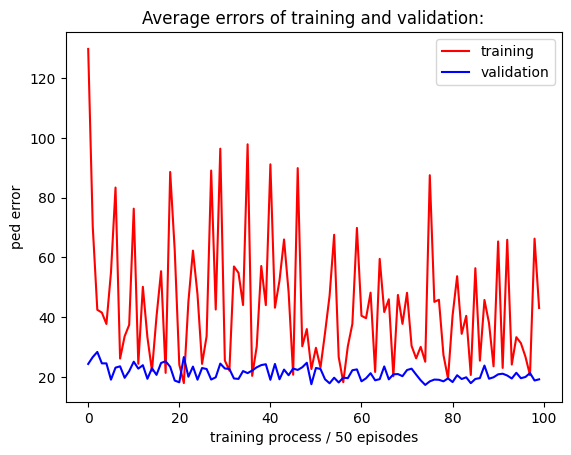

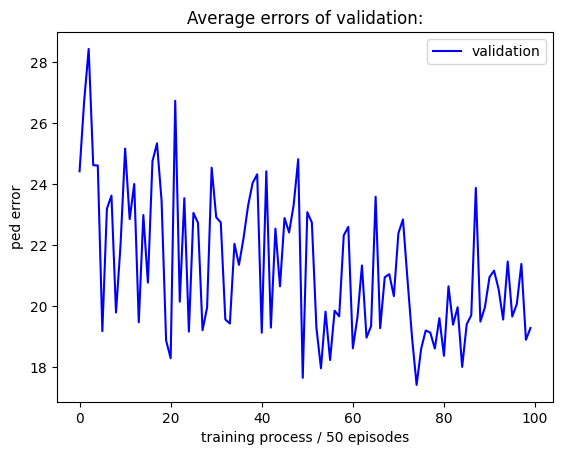

In [6]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, label='ped')